<a href="https://colab.research.google.com/github/noahbean33/computational_physics_experiments/blob/main/maxwells_equations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

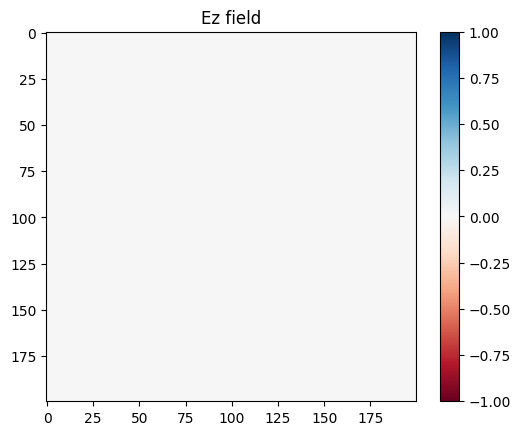

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Constants
c = 3e8  # Speed of light in vacuum
eps0 = 8.854e-12  # Permittivity of free space
mu0 = 4 * np.pi * 1e-7  # Permeability of free space

# Simulation parameters
dx = dy = 1e-6  # Space step (1 micron)
dt = dx / (2 * c)  # Time step
nx, ny = 200, 200  # Grid size
nsteps = 1000  # Number of time steps

# Field arrays
Ez = np.zeros((nx, ny))
Hx = np.zeros((nx, ny))
Hy = np.zeros((nx, ny))

# Source parameters
source_position = (nx // 2, ny // 2)
frequency = 1e14  # Source frequency (100 THz)

# Update coefficients
ca = dt / eps0 / dx
cb = dt / mu0 / dx

def update_fields(Ez, Hx, Hy):
    # Update Hx and Hy
    Hx[:-1, :] -= cb * (Ez[1:, :] - Ez[:-1, :])
    Hy[:, :-1] += cb * (Ez[:, 1:] - Ez[:, :-1])

    # Update Ez
    Ez[1:, 1:] += ca * ((Hy[1:, 1:] - Hy[:-1, 1:]) - (Hx[1:, 1:] - Hx[1:, :-1]))

    return Ez, Hx, Hy

# Visualization setup
fig, ax = plt.subplots()
im = ax.imshow(Ez, cmap='RdBu', vmin=-1, vmax=1, interpolation='bilinear')
ax.set_title('Ez field')
fig.colorbar(im)

def animate(i):
    global Ez, Hx, Hy
    Ez[source_position] = np.sin(2 * np.pi * frequency * dt * i)  # Source
    Ez, Hx, Hy = update_fields(Ez, Hx, Hy)
    im.set_array(Ez)
    return [im]

ani = FuncAnimation(fig, animate, frames=nsteps, blit=True)
plt.show()


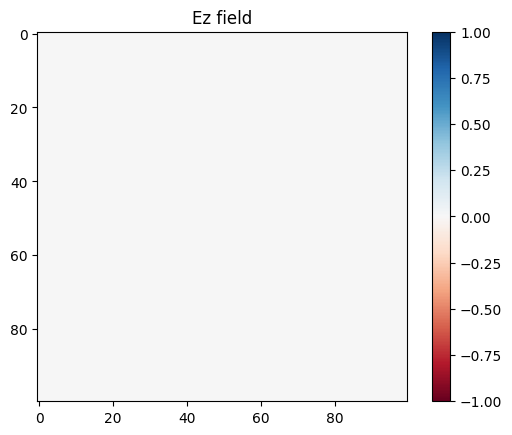

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from numba import jit

# Constants
c = 3e8  # Speed of light in vacuum
eps0 = 8.854e-12  # Permittivity of free space
mu0 = 4 * np.pi * 1e-7  # Permeability of free space

# Simulation parameters
dx = dy = dz = 1e-6  # Space step (1 micron)
dt = dx / (2 * c)  # Time step
nx, ny, nz = 100, 100, 100  # Grid size
nsteps = 200  # Number of time steps
pml_size = 10  # Size of the PML

# Field arrays
Ez = np.zeros((nx, ny, nz))
Hx = np.zeros((nx, ny, nz))
Hy = np.zeros((nx, ny, nz))
Hz = np.zeros((nx, ny, nz))

# Material properties arrays
epsilon = np.ones((nx, ny, nz)) * eps0
mu = np.ones((nx, ny, nz)) * mu0

# Source parameters
source_position = (nx // 2, ny // 2, nz // 2)
frequency = 1e14  # Source frequency (100 THz)

# PML parameters
sigma_max = 1.0
pml_sigma_x = np.zeros((nx, ny, nz))
pml_sigma_y = np.zeros((nx, ny, nz))
pml_sigma_z = np.zeros((nx, ny, nz))

# Initialize PML
def init_pml(pml_sigma, size, sigma_max, axis_size):
    for i in range(size):
        sigma = sigma_max * (i / size) ** 2
        pml_sigma[i, :, :] = sigma
        pml_sigma[axis_size - i - 1, :, :] = sigma
        pml_sigma[:, i, :] = sigma
        pml_sigma[:, axis_size - i - 1, :] = sigma
        pml_sigma[:, :, i] = sigma
        pml_sigma[:, :, axis_size - i - 1] = sigma

init_pml(pml_sigma_x, pml_size, sigma_max, nx)
init_pml(pml_sigma_y, pml_size, sigma_max, ny)
init_pml(pml_sigma_z, pml_size, sigma_max, nz)

# Update coefficients
ca = dt / epsilon
cb = dt / mu

@jit(nopython=True)
def update_fields(Ez, Hx, Hy, Hz, pml_sigma_x, pml_sigma_y, pml_sigma_z, ca, cb, nx, ny, nz):
    # Update Hx
    Hx[:, :-1, :-1] -= cb[:, :-1, :-1] * ((Ez[:, 1:, :-1] - Ez[:, :-1, :-1]) / dy - (Ez[:, :-1, 1:] - Ez[:, :-1, :-1]) / dz)
    Hx *= (1 - pml_sigma_y[:, :-1, :-1]) * (1 - pml_sigma_z[:, :-1, :-1])

    # Update Hy
    Hy[:-1, :, :-1] += cb[:-1, :, :-1] * ((Ez[1:, :, :-1] - Ez[:-1, :, :-1]) / dx - (Ez[:-1, :, 1:] - Ez[:-1, :, :-1]) / dz)
    Hy *= (1 - pml_sigma_x[:-1, :, :-1]) * (1 - pml_sigma_z[:-1, :, :-1])

    # Update Hz
    Hz[:-1, :-1, :] -= cb[:-1, :-1, :] * ((Ez[1:, :-1, :] - Ez[:-1, :-1, :]) / dx - (Ez[:-1, 1:, :] - Ez[:-1, :-1, :]) / dy)
    Hz *= (1 - pml_sigma_x[:-1, :-1, :]) * (1 - pml_sigma_y[:-1, :-1, :])

    # Update Ez
    Ez[1:, 1:, 1:] += ca[1:, 1:, 1:] * ((Hy[1:, 1:, 1:] - Hy[:-1, 1:, 1:]) / dx - (Hx[1:, 1:, 1:] - Hx[1:, :-1, 1:]) / dy)
    Ez *= (1 - pml_sigma_x[1:, 1:, 1:]) * (1 - pml_sigma_y[1:, 1:, 1:]) * (1 - pml_sigma_z[1:, 1:, 1:])

    return Ez, Hx, Hy, Hz

# Visualization setup
fig, ax = plt.subplots()
im = ax.imshow(Ez[:, :, nz // 2], cmap='RdBu', vmin=-1, vmax=1, interpolation='bilinear')
ax.set_title('Ez field')
fig.colorbar(im)

def animate(i):
    global Ez, Hx, Hy, Hz
    Ez[source_position] = np.sin(2 * np.pi * frequency * dt * i)  # Source
    Ez, Hx, Hy, Hz = update_fields(Ez, Hx, Hy, Hz, pml_sigma_x, pml_sigma_y, pml_sigma_z, ca, cb, nx, ny, nz)
    im.set_array(Ez[:, :, nz // 2])
    return [im]

ani = FuncAnimation(fig, animate, frames=nsteps, blit=True)
plt.show()


In [3]:
!pip install numba


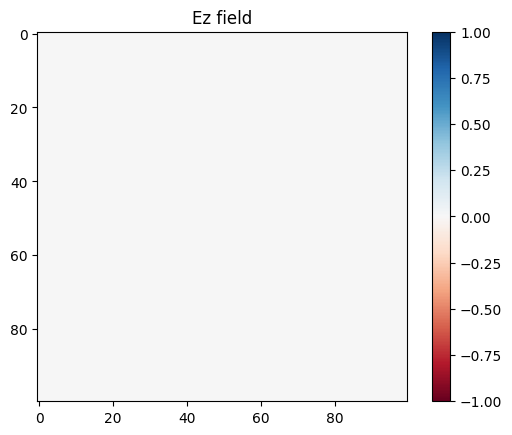

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from numba import jit

# Constants
c = 3e8  # Speed of light in vacuum
eps0 = 8.854e-12  # Permittivity of free space
mu0 = 4 * np.pi * 1e-7  # Permeability of free space

# Simulation parameters
dx = dy = dz = 1e-6  # Space step (1 micron)
dt = dx / (2 * c)  # Time step
nx, ny, nz = 100, 100, 100  # Grid size
nsteps = 200  # Number of time steps
pml_size = 10  # Size of the PML

# Field arrays
Ez = np.zeros((nx, ny, nz))
Hx = np.zeros((nx, ny, nz))
Hy = np.zeros((nx, ny, nz))
Hz = np.zeros((nx, ny, nz))

# Material properties arrays
epsilon = np.ones((nx, ny, nz)) * eps0
mu = np.ones((nx, ny, nz)) * mu0

# Source parameters
source_position = (nx // 2, ny // 2, nz // 2)
frequency = 1e14  # Source frequency (100 THz)

# PML parameters
sigma_max = 1.0
pml_sigma_x = np.zeros((nx, ny, nz))
pml_sigma_y = np.zeros((nx, ny, nz))
pml_sigma_z = np.zeros((nx, ny, nz))

# Initialize PML
def init_pml(pml_sigma, size, sigma_max, axis_size):
    for i in range(size):
        sigma = sigma_max * (i / size) ** 2
        pml_sigma[i, :, :] = sigma
        pml_sigma[axis_size - i - 1, :, :] = sigma
        pml_sigma[:, i, :] = sigma
        pml_sigma[:, axis_size - i - 1, :] = sigma
        pml_sigma[:, :, i] = sigma
        pml_sigma[:, :, axis_size - i - 1] = sigma

init_pml(pml_sigma_x, pml_size, sigma_max, nx)
init_pml(pml_sigma_y, pml_size, sigma_max, ny)
init_pml(pml_sigma_z, pml_size, sigma_max, nz)

# Update coefficients
ca = dt / epsilon
cb = dt / mu

@jit(nopython=True)
def update_fields(Ez, Hx, Hy, Hz, pml_sigma_x, pml_sigma_y, pml_sigma_z, ca, cb, nx, ny, nz):
    # Update Hx
    Hx[:, :-1, :-1] -= cb[:, :-1, :-1] * ((Ez[:, 1:, :-1] - Ez[:, :-1, :-1]) / dy - (Ez[:, :-1, 1:] - Ez[:, :-1, :-1]) / dz)
    Hx *= (1 - pml_sigma_y[:, :-1, :-1]) * (1 - pml_sigma_z[:, :-1, :-1])

    # Update Hy
    Hy[:-1, :, :-1] += cb[:-1, :, :-1] * ((Ez[1:, :, :-1] - Ez[:-1, :, :-1]) / dx - (Ez[:-1, :, 1:] - Ez[:-1, :, :-1]) / dz)
    Hy *= (1 - pml_sigma_x[:-1, :, :-1]) * (1 - pml_sigma_z[:-1, :, :-1])

    # Update Hz
    Hz[:-1, :-1, :] -= cb[:-1, :-1, :] * ((Ez[1:, :-1, :] - Ez[:-1, :-1, :]) / dx - (Ez[:-1, 1:, :] - Ez[:-1, :-1, :]) / dy)
    Hz *= (1 - pml_sigma_x[:-1, :-1, :]) * (1 - pml_sigma_y[:-1, :-1, :])

    # Update Ez
    Ez[1:, 1:, 1:] += ca[1:, 1:, 1:] * ((Hy[1:, 1:, 1:] - Hy[:-1, 1:, 1:]) / dx - (Hx[1:, 1:, 1:] - Hx[1:, :-1, 1:]) / dy)
    Ez *= (1 - pml_sigma_x[1:, 1:, 1:]) * (1 - pml_sigma_y[1:, 1:, 1:]) * (1 - pml_sigma_z[1:, 1:, 1:])

    return Ez, Hx, Hy, Hz

# Visualization setup
fig, ax = plt.subplots()
im = ax.imshow(Ez[:, :, nz // 2], cmap='RdBu', vmin=-1, vmax=1, interpolation='bilinear')
ax.set_title('Ez field')
fig.colorbar(im)

def animate(i):
    global Ez, Hx, Hy, Hz
    Ez[source_position] = np.sin(2 * np.pi * frequency * dt * i)  # Source
    Ez, Hx, Hy, Hz = update_fields(Ez, Hx, Hy, Hz, pml_sigma_x, pml_sigma_y, pml_sigma_z, ca, cb, nx, ny, nz)
    im.set_array(Ez[:, :, nz // 2])
    return [im]

ani = FuncAnimation(fig, animate, frames=nsteps, blit=True)
plt.show()


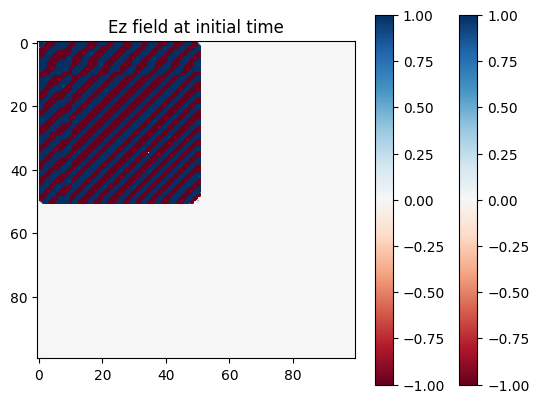

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from numba import jit

# Constants
c = 3e8  # Speed of light in vacuum
eps0 = 8.854e-12  # Permittivity of free space
mu0 = 4 * np.pi * 1e-7  # Permeability of free space

# Simulation parameters
dx = dy = dz = 1e-6  # Space step (1 micron)
dt = dx / (2 * c)  # Time step
nx, ny, nz = 100, 100, 100  # Grid size
nsteps = 200  # Number of time steps
pml_size = 10  # Size of the PML

# Field arrays
Ez = np.zeros((nx, ny, nz))
Hx = np.zeros((nx, ny, nz))
Hy = np.zeros((nx, ny, nz))
Hz = np.zeros((nx, ny, nz))

# Material properties arrays
epsilon = np.ones((nx, ny, nz)) * eps0
mu = np.ones((nx, ny, nz)) * mu0

# Source parameters
source_position = (nx // 2, ny // 2, nz // 2)
frequency = 1e14  # Source frequency (100 THz)

# PML parameters
sigma_max = 1.0
pml_sigma_x = np.zeros((nx, ny, nz))
pml_sigma_y = np.zeros((nx, ny, nz))
pml_sigma_z = np.zeros((nx, ny, nz))

# Initialize PML
def init_pml(pml_sigma, size, sigma_max, axis_size):
    for i in range(size):
        sigma = sigma_max * (i / size) ** 2
        pml_sigma[i, :, :] = sigma
        pml_sigma[axis_size - i - 1, :, :] = sigma
        pml_sigma[:, i, :] = sigma
        pml_sigma[:, axis_size - i - 1, :] = sigma
        pml_sigma[:, :, i] = sigma
        pml_sigma[:, :, axis_size - i - 1] = sigma

init_pml(pml_sigma_x, pml_size, sigma_max, nx)
init_pml(pml_sigma_y, pml_size, sigma_max, ny)
init_pml(pml_sigma_z, pml_size, sigma_max, nz)

# Update coefficients
ca = dt / epsilon
cb = dt / mu

@jit(nopython=True)
def update_fields(Ez, Hx, Hy, Hz, pml_sigma_x, pml_sigma_y, pml_sigma_z, ca, cb, nx, ny, nz):
    # Update Hx
    Hx[:, :-1, :-1] -= cb[:, :-1, :-1] * ((Ez[:, 1:, :-1] - Ez[:, :-1, :-1]) / dy - (Ez[:, :-1, 1:] - Ez[:, :-1, :-1]) / dz)
    Hx *= (1 - pml_sigma_y[:, :-1, :-1]) * (1 - pml_sigma_z[:, :-1, :-1])

    # Update Hy
    Hy[:-1, :, :-1] += cb[:-1, :, :-1] * ((Ez[1:, :, :-1] - Ez[:-1, :, :-1]) / dx - (Ez[:-1, :, 1:] - Ez[:-1, :, :-1]) / dz)
    Hy *= (1 - pml_sigma_x[:-1, :, :-1]) * (1 - pml_sigma_z[:-1, :, :-1])

    # Update Hz
    Hz[:-1, :-1, :] -= cb[:-1, :-1, :] * ((Ez[1:, :-1, :] - Ez[:-1, :-1, :]) / dx - (Ez[:-1, 1:, :] - Ez[:-1, :-1, :]) / dy)
    Hz *= (1 - pml_sigma_x[:-1, :-1, :]) * (1 - pml_sigma_y[:-1, :-1, :])

    # Update Ez
    Ez[1:, 1:, 1:] += ca[1:, 1:, 1:] * ((Hy[1:, 1:, 1:] - Hy[:-1, 1:, 1:]) / dx - (Hx[1:, 1:, 1:] - Hx[1:, :-1, 1:]) / dy)
    Ez *= (1 - pml_sigma_x[1:, 1:, 1:]) * (1 - pml_sigma_y[1:, 1:, 1:]) * (1 - pml_sigma_z[1:, 1:, 1:])

    return Ez, Hx, Hy, Hz

# Visualization setup
fig, ax = plt.subplots()
im = ax.imshow(Ez[:, :, nz // 2], cmap='RdBu', vmin=-1, vmax=1, interpolation='bilinear')
ax.set_title('Ez field')
fig.colorbar(im)

# Function to update the plot
def animate(i):
    global Ez, Hx, Hy, Hz
    Ez[source_position] = np.sin(2 * np.pi * frequency * dt * i)  # Source
    Ez, Hx, Hy, Hz = update_fields(Ez, Hx, Hy, Hz, pml_sigma_x, pml_sigma_y, pml_sigma_z, ca, cb, nx, ny, nz)
    im.set_array(Ez[:, :, nz // 2])
    return [im]

# Create and save the animation
ani = FuncAnimation(fig, animate, frames=nsteps, blit=True)
writer = PillowWriter(fps=20)
ani.save("fdtd_simulation.gif", writer=writer)

# Display the first frame to check
plt.imshow(Ez[:, :, nz // 2], cmap='RdBu', vmin=-1, vmax=1, interpolation='bilinear')
plt.title('Ez field at initial time')
plt.colorbar()
plt.show()


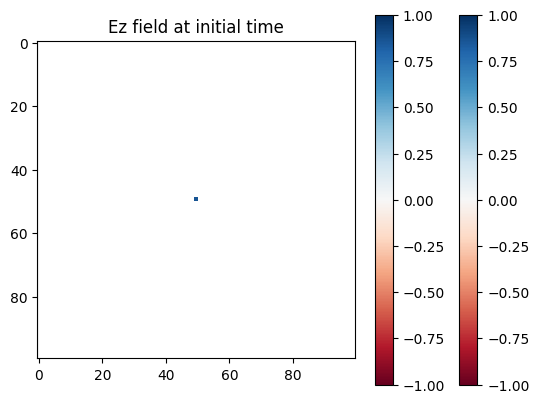

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from numba import jit

# Constants
c = 3e8  # Speed of light in vacuum
eps0 = 8.854e-12  # Permittivity of free space
mu0 = 4 * np.pi * 1e-7  # Permeability of free space

# Simulation parameters
dx = dy = dz = 1e-6  # Space step (1 micron)
dt = dx / (2 * c)  # Time step
nx, ny, nz = 100, 100, 100  # Grid size
nsteps = 200  # Number of time steps
pml_size = 10  # Size of the PML

# Field arrays
Ez = np.zeros((nx, ny, nz))
Hx = np.zeros((nx, ny, nz))
Hy = np.zeros((nx, ny, nz))
Hz = np.zeros((nx, ny, nz))

# Material properties arrays
epsilon = np.ones((nx, ny, nz)) * eps0
mu = np.ones((nx, ny, nz)) * mu0

# Source parameters
source_position = (nx // 2, ny // 2, nz // 2)
frequency = 1e14  # Source frequency (100 THz)

# PML parameters
sigma_max = 1.0
pml_sigma_x = np.zeros((nx, ny, nz))
pml_sigma_y = np.zeros((nx, ny, nz))
pml_sigma_z = np.zeros((nx, ny, nz))

# Initialize PML
def init_pml(pml_sigma, size, sigma_max, axis_size):
    for i in range(size):
        sigma = sigma_max * (i / size) ** 2
        pml_sigma[i, :, :] = sigma
        pml_sigma[axis_size - i - 1, :, :] = sigma
        pml_sigma[:, i, :] = sigma
        pml_sigma[:, axis_size - i - 1, :] = sigma
        pml_sigma[:, :, i] = sigma
        pml_sigma[:, :, axis_size - i - 1] = sigma

init_pml(pml_sigma_x, pml_size, sigma_max, nx)
init_pml(pml_sigma_y, pml_size, sigma_max, ny)
init_pml(pml_sigma_z, pml_size, sigma_max, nz)

# Update coefficients
ca = dt / epsilon
cb = dt / mu

@jit(nopython=True)
def update_fields(Ez, Hx, Hy, Hz, pml_sigma_x, pml_sigma_y, pml_sigma_z, ca, cb, nx, ny, nz):
    # Update Hx
    Hx[:, :-1, :-1] -= cb[:, :-1, :-1] * ((Ez[:, 1:, :-1] - Ez[:, :-1, :-1]) / dy - (Ez[:, :-1, 1:] - Ez[:, :-1, :-1]) / dz)
    Hx *= (1 - pml_sigma_y[:, :-1, :-1]) * (1 - pml_sigma_z[:, :-1, :-1])

    # Update Hy
    Hy[:-1, :, :-1] += cb[:-1, :, :-1] * ((Ez[1:, :, :-1] - Ez[:-1, :, :-1]) / dx - (Ez[:-1, :, 1:] - Ez[:-1, :, :-1]) / dz)
    Hy *= (1 - pml_sigma_x[:-1, :, :-1]) * (1 - pml_sigma_z[:-1, :, :-1])

    # Update Hz
    Hz[:-1, :-1, :] -= cb[:-1, :-1, :] * ((Ez[1:, :-1, :] - Ez[:-1, :-1, :]) / dx - (Ez[:-1, 1:, :] - Ez[:-1, :-1, :]) / dy)
    Hz *= (1 - pml_sigma_x[:-1, :-1, :]) * (1 - pml_sigma_y[:-1, :-1, :])

    # Update Ez
    Ez[1:, 1:, 1:] += ca[1:, 1:, 1:] * ((Hy[1:, 1:, 1:] - Hy[:-1, 1:, 1:]) / dx - (Hx[1:, 1:, 1:] - Hx[1:, :-1, 1:]) / dy)
    Ez *= (1 - pml_sigma_x[1:, 1:, 1:]) * (1 - pml_sigma_y[1:, 1:, 1:]) * (1 - pml_sigma_z[1:, 1:, 1:])

    return Ez, Hx, Hy, Hz

# Function to update the plot
def animate(i):
    global Ez, Hx, Hy, Hz
    Ez[source_position[0]-2:source_position[0]+2,
       source_position[1]-2:source_position[1]+2,
       source_position[2]-2:source_position[2]+2] = np.sin(2 * np.pi * frequency * dt * i)  # Source
    Ez, Hx, Hy, Hz = update_fields(Ez, Hx, Hy, Hz, pml_sigma_x, pml_sigma_y, pml_sigma_z, ca, cb, nx, ny, nz)
    im.set_array(Ez[:, :, nz // 2])
    return [im]

# Visualization setup
fig, ax = plt.subplots()
im = ax.imshow(Ez[:, :, nz // 2], cmap='RdBu', vmin=-1, vmax=1, interpolation='bilinear')
ax.set_title('Ez field')
fig.colorbar(im)

# Create and save the animation
ani = FuncAnimation(fig, animate, frames=nsteps, blit=True)
writer = PillowWriter(fps=20)
ani.save("fdtd_simulation.gif", writer=writer)

# Display the first frame to check
plt.imshow(Ez[:, :, nz // 2], cmap='RdBu', vmin=-1, vmax=1, interpolation='bilinear')
plt.title('Ez field at initial time')
plt.colorbar()
plt.show()


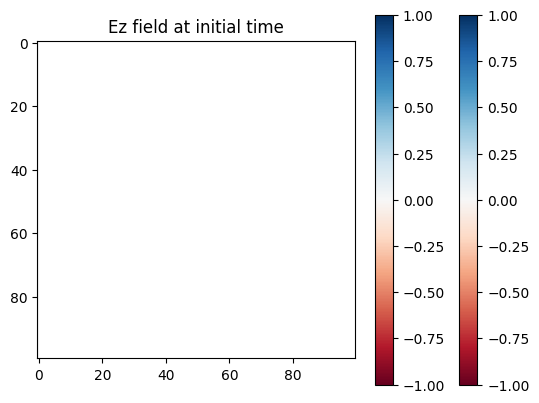

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from numba import jit

# Constants
c = 3e8  # Speed of light in vacuum
eps0 = 8.854e-12  # Permittivity of free space
mu0 = 4 * np.pi * 1e-7  # Permeability of free space

# Simulation parameters
dx = dy = dz = 1e-6  # Space step (1 micron)
dt = dx / (2 * c)  # Time step
nx, ny, nz = 100, 100, 100  # Grid size
nsteps = 200  # Number of time steps
pml_size = 10  # Size of the PML

# Field arrays
Ez = np.zeros((nx, ny, nz))
Hx = np.zeros((nx, ny, nz))
Hy = np.zeros((nx, ny, nz))
Hz = np.zeros((nx, ny, nz))

# Material properties arrays
epsilon = np.ones((nx, ny, nz)) * eps0
mu = np.ones((nx, ny, nz)) * mu0

# Source parameters
source_position = (nx // 2, ny // 2, nz // 2)
frequency = 1e14  # Source frequency (100 THz)

# PML parameters
sigma_max = 1.0
pml_sigma_x = np.zeros((nx, ny, nz))
pml_sigma_y = np.zeros((nx, ny, nz))
pml_sigma_z = np.zeros((nx, ny, nz))

# Initialize PML
def init_pml(pml_sigma, size, sigma_max, axis_size):
    for i in range(size):
        sigma = sigma_max * (i / size) ** 2
        pml_sigma[i, :, :] = sigma
        pml_sigma[axis_size - i - 1, :, :] = sigma
        pml_sigma[:, i, :] = sigma
        pml_sigma[:, axis_size - i - 1, :] = sigma
        pml_sigma[:, :, i] = sigma
        pml_sigma[:, :, axis_size - i - 1] = sigma

init_pml(pml_sigma_x, pml_size, sigma_max, nx)
init_pml(pml_sigma_y, pml_size, sigma_max, ny)
init_pml(pml_sigma_z, pml_size, sigma_max, nz)

# Update coefficients
ca = dt / epsilon
cb = dt / mu

@jit(nopython=True)
def update_fields(Ez, Hx, Hy, Hz, pml_sigma_x, pml_sigma_y, pml_sigma_z, ca, cb, nx, ny, nz):
    # Update Hx
    Hx[:, :-1, :-1] -= cb[:, :-1, :-1] * ((Ez[:, 1:, :-1] - Ez[:, :-1, :-1]) / dy - (Ez[:, :-1, 1:] - Ez[:, :-1, :-1]) / dz)
    Hx *= (1 - pml_sigma_y[:, :-1, :-1]) * (1 - pml_sigma_z[:, :-1, :-1])

    # Update Hy
    Hy[:-1, :, :-1] += cb[:-1, :, :-1] * ((Ez[1:, :, :-1] - Ez[:-1, :, :-1]) / dx - (Ez[:-1, :, 1:] - Ez[:-1, :, :-1]) / dz)
    Hy *= (1 - pml_sigma_x[:-1, :, :-1]) * (1 - pml_sigma_z[:-1, :, :-1])

    # Update Hz
    Hz[:-1, :-1, :] -= cb[:-1, :-1, :] * ((Ez[1:, :-1, :] - Ez[:-1, :-1, :]) / dx - (Ez[:-1, 1:, :] - Ez[:-1, :-1, :]) / dy)
    Hz *= (1 - pml_sigma_x[:-1, :-1, :]) * (1 - pml_sigma_y[:-1, :-1, :])

    # Update Ez
    Ez[1:, 1:, 1:] += ca[1:, 1:, 1:] * ((Hy[1:, 1:, 1:] - Hy[:-1, 1:, 1:]) / dx - (Hx[1:, 1:, 1:] - Hx[1:, :-1, 1:]) / dy)
    Ez *= (1 - pml_sigma_x[1:, 1:, 1:]) * (1 - pml_sigma_y[1:, 1:, 1:]) * (1 - pml_sigma_z[1:, 1:, 1:])

    return Ez, Hx, Hy, Hz

# Visualization setup
fig, ax = plt.subplots()
im = ax.imshow(Ez[:, :, nz // 2], cmap='RdBu', vmin=-1, vmax=1, interpolation='bilinear')
ax.set_title('Ez field')
fig.colorbar(im)

def animate(i):
    global Ez, Hx, Hy, Hz
    Ez[source_position[0]-1:source_position[0]+2,
       source_position[1]-1:source_position[1]+2,
       source_position[2]-1:source_position[2]+2] = np.sin(2 * np.pi * frequency * dt * i)  # Source
    Ez, Hx, Hy, Hz = update_fields(Ez, Hx, Hy, Hz, pml_sigma_x, pml_sigma_y, pml_sigma_z, ca, cb, nx, ny, nz)
    im.set_array(Ez[:, :, nz // 2])
    return [im]

# Create and save the animation
ani = FuncAnimation(fig, animate, frames=nsteps, blit=True)
writer = PillowWriter(fps=20)
ani.save("fdtd_simulation.gif", writer=writer)

# Display the first frame to check
plt.imshow(Ez[:, :, nz // 2], cmap='RdBu', vmin=-1, vmax=1, interpolation='bilinear')
plt.title('Ez field at initial time')
plt.colorbar()
plt.show()
